# Part 1  

In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline


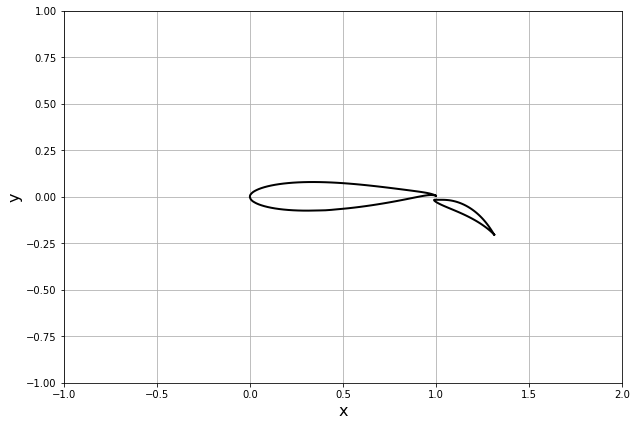

In [2]:
x,y= numpy.loadtxt("MainFoil_N=100-Copy1.csv", delimiter=',', unpack=True)
e,f= numpy.loadtxt("FlapFoil_N=100-Copy1.csv", delimiter=',', unpack=True)
# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(e, f, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1, 2)
pyplot.ylim(-1, 1);

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [4]:
def panels1 (c,d,N):
    panels = numpy.empty(N, dtype=Panel)
    for i in range(N):
        panels[i] = Panel(c[i], d[i], c[i + 1], d[i + 1])
    return panels
    

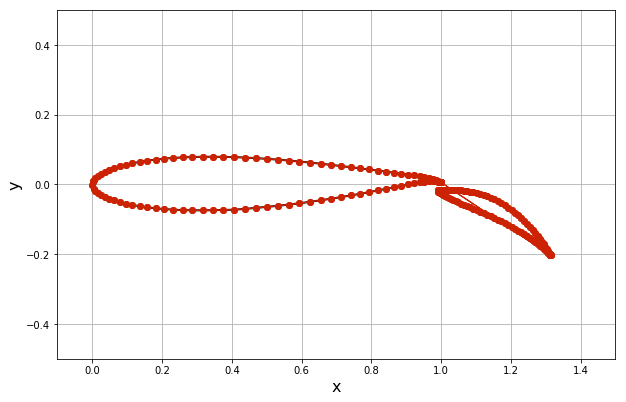

In [5]:
N = len(x)-1                           # number of panels
panels_main = panels1(x, y, N)  # discretizes of the geometry into panels
panels_foil = panels1(e, f, N)
panels = numpy.concatenate((panels_main,panels_foil))

# plot the geometry and the panels
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(e, f, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels_main[0].xa),
            numpy.append([panel.ya for panel in panels], panels_main[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')

pyplot.plot(numpy.append([panel.xa for panel in panels], panels_foil[0].xa),
            numpy.append([panel.ya for panel in panels], panels_foil[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.5, 0.5);

In [6]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf, alpha):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees --> radians

In [7]:
u_inf = 1.0                            # freestream speed
alpha = 0.0                            # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)# instantiation of the object freestream


In [8]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [9]:
def source_contribution_normal(panels):
    
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

In [10]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

In [11]:
A_source = source_contribution_normal(panels) 
B_vortex = vortex_contribution_normal(panels) 
print (A_source.shape)

(200, 200)


In [12]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 2D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty((2,A_source.shape[0]+2), dtype=float) # filling the matrix with values from B_vortex and A_source
    
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[0,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[0,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    
    b[1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])

    
    return b

In [13]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """    
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    
    
    return A

In [14]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
1
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size + 2, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[N].beta) +
                                 numpy.sin(freestream.alpha - panels[2*N-1].beta) )
    
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[N-1].beta) )
    
    return b

In [15]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream) 


In [16]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
# store circulation density
gamma = strengths[-2:]

## Computing Cp

In [17]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size + 2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)

    # freestream contribution
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
        

In [18]:

compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)


In [19]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [20]:
compute_pressure_coefficient(panels, freestream)

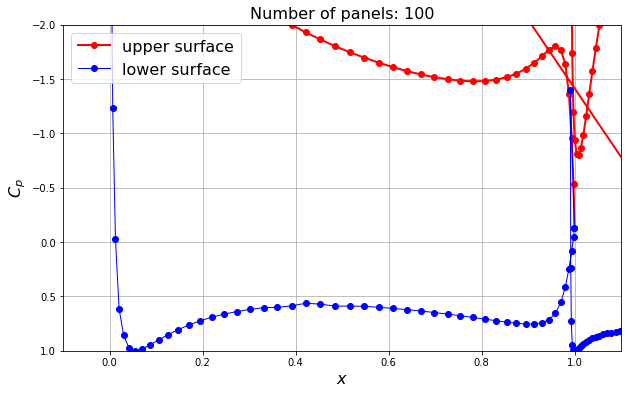

In [21]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(panels_main.size), fontsize=16);
pyplot.title('Number of panels: {}'.format(panels_foil.size), fontsize=16);

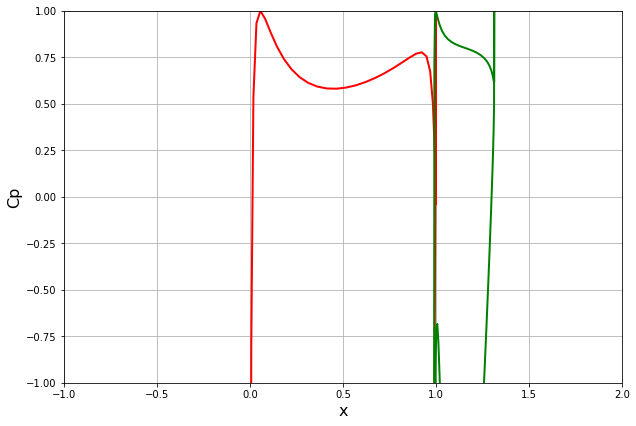

In [22]:
# Comparing the above graph with the imported graph
g,h= numpy.loadtxt("Cp_Main_theoretical-Copy1.csv", delimiter=',', unpack=True)
j,k= numpy.loadtxt("Cp_Flap_theoretical-Copy1.csv", delimiter=',', unpack=True)

# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('Cp', fontsize=16)
pyplot.plot(g, h, color='red', linestyle='-', linewidth=2)
pyplot.plot(j, k, color='green', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-1, 2)
pyplot.ylim(-1, 1);

In [23]:
# Q1. What is the pressure coefficient on the  3 rd panel on the main airfoil?

# Ans. 1 

print (panels[2].cp)

-0.955701172981


In [24]:
# Q2. What is the pressure coefficient on the  10th panel on the flap airfoil?

# Ans. 2 

print (panels[109].cp)

-0.279918398369


In [25]:
# Q3 and Q4. What is the value of lift and Drag?
# Ans. 3 lift=cp*length*sin(beta), drag=cp*Length*cos(beta)
lift_force,drag_force=0.0,0.0
for panel in panels:
    lift_force -= panel.length*numpy.sin(panel.beta)*panel.cp
    drag_force += panel.length*numpy.cos(panel.beta)*panel.cp
print("The lift and drag force:",lift_force,"and",drag_force)

The lift and drag force: 3.69771447686 and 0.0107914032459


In [26]:
# Q5.  What is the percentage of improvement of the absolute error on the lift force? Round your answer to the nearest whole number.
# Ans. 5
Lift_100 = 3.69771447686
Lift_200 = 3.71843390868
Lift_theo= 3.7386
error_100=Lift_theo-Lift_100
error_200=Lift_theo-Lift_200
pererror= ((error_100-error_200)/error_100)*100
print ("Percentage error is : ",pererror,"%")

Percentage error is :  50.67669490017901 %


# Part 2 

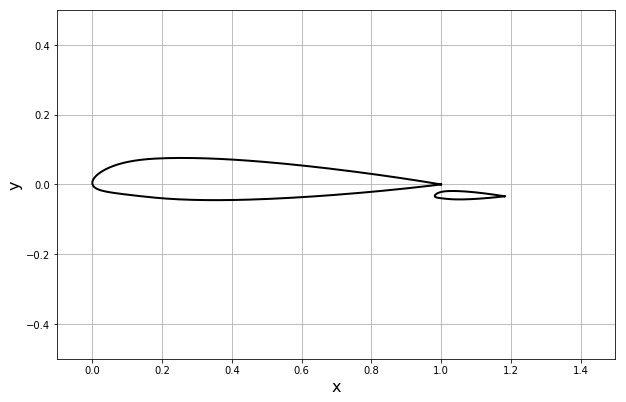

In [27]:
g,h= numpy.loadtxt("NACA23012_MainFoil.csv", delimiter=',', unpack=True)
j,k= numpy.loadtxt("NACA23012_FlapFoil.csv", delimiter=',', unpack=True)
N = len(g)-1                           # number of panels
panels_main2 = panels1(g, h, N)  # discretizes of the geometry into panels
panels_foil2 = panels1(j, k, N)

# plot the geometry and the panels
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(g, h, color='k', linestyle='-', linewidth=2)
pyplot.plot(j, k, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.5, 0.5);

In [28]:
def rotating_the_matrix(ox,oy,xhinge,yhinge,angle):
    theta=(angle*math.pi/180)
    x_rot =  math.cos(theta) * (-xhinge + ox) + math.sin(theta) * (-yhinge + oy)
    y_rot =  -math.sin(theta) * (-xhinge + ox) + math.cos(theta) * (-yhinge + oy)
    return x_rot,y_rot

In [29]:
xhinge = 1.03 # x and y coordinates of flap foil hinge
yhinge = -0.054
j_r,k_r = rotating_the_matrix(j,k,xhinge,yhinge,20)
j_new = j_r + xhinge
k_new = k_r +yhinge

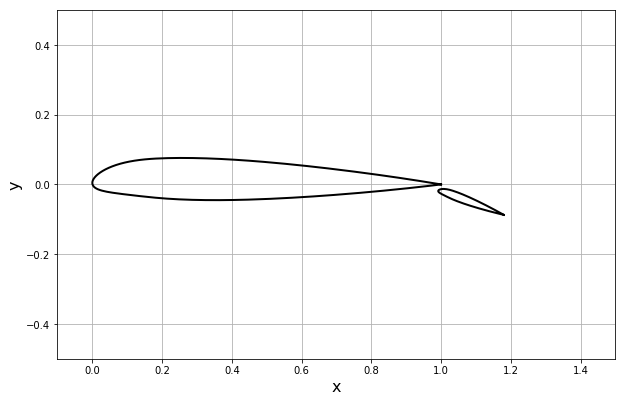

In [30]:
width = 10 # Plotting the foil with 20deg. angle of attack
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(g, h, color='k', linestyle='-', linewidth=2)
pyplot.plot(j_new, k_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.5, 0.5);

In [31]:
def lift_calculations (panels_150,freestream_new):
        
    A_source_new = source_contribution_normal(panels_150)
    B_vortex_new = vortex_contribution_normal(panels_150) 
    A_new = build_singularity_matrix(A_source_new, B_vortex_new)
    b_new = build_freestream_rhs(panels_150, freestream_new) 
    # solve for singularity strengths
    strengths_new = numpy.linalg.solve(A_new, b_new)

   # store source strength on each panel
    for i , panel in enumerate(panels_150):
        panel.sigma = strengths_new[i]
# store circulation density
    
    gamma_new = strengths_new[-2:]
    
    compute_tangential_velocity(panels_150, freestream_new, gamma_new, A_source_new, B_vortex_new)

    compute_pressure_coefficient(panels_150, freestream_new)
    
    lift_force_new = 0.0
    for panel in panels_150:
        lift_force_new -= panel.length*numpy.sin(panel.beta)*panel.cp
    return lift_force_new


In [32]:
def rotationPanel(angle):
    j_r,k_r = rotating_the_matrix(j,k,xhinge,yhinge,angle)
    j_new = j_r + xhinge
    k_new = k_r +yhinge
    panels_foil2 = numpy.empty(N, dtype=object)
    panels_foil2 = panels1(j_new,k_new,N)
    panels_150 = numpy.concatenate((panels_main2,panels_foil2))
    return panels_150

In [33]:
def Bisection_method_alpha(Lift_initial, panels_150, alpha1, alpha2, tolerance, theta):

    for x in range(1, 50):
        alpha = (alpha1+alpha2)/2
        freestream_2 = Freestream(u_inf, alpha)
        panels_150=rotationPanel(theta)
        Lift=lift_calculations (panels_150,freestream_2)
        print('Alpha and Lift:', alpha, Lift)
        if (alpha2-alpha1)/2 < tolerance: 
            print("Lift found")
            break

        if ((Lift<0 and Lift_initial<0)or(Lift>0 and Lift_initial>0)or(Lift==0 and Lift_initial==0)):
            alpha1 = alpha
            Lift_initial=Lift
        else:
            alpha2 = alpha
    return alpha

In [34]:
def Bisection_method_theta(Lift_initial, panels_150, theta1, theta2, tolerance, alpha):
    for x in range(1, 50):
        theta = (theta1+theta2)/2
        freestream_2 = Freestream(u_inf, alpha)
        panels_150=rotationPanel(theta)
        Lift=lift_calculations (panels_150,freestream_2)
        print('Theta and Lift:', theta, Lift)
        if abs(theta2-theta1)/2 < tolerance: 
            print("Theta found")
            break

        if ((Lift<0 and Lift_initial<0)or(Lift>0 and Lift_initial>0)or(Lift==0 and Lift_initial==0)):
            theta1 = theta
            Lift_initial=Lift
        else:
            theta2 = theta
    return theta


In [35]:
# Q1. Use the bisection method to determine the angle of attack,  αα , that will cause zero lift when the flap angle is  20º. Round your answer to the second digit after the floating point.
# Ans.

In [36]:
theta = 20.0
u_inf = 1.0
tolerance = 0.01
alpha1, alpha2 = -14.0, 0.0
freestream_1 = Freestream(u_inf, alpha1)# instantiation of the object freestream
panels_150=rotationPanel(theta)
Lift_initial=lift_calculations (panels_150,freestream_1)

alpha_final = Bisection_method_alpha(Lift_initial, panels_150, alpha1, alpha2, tolerance, theta)


Alpha and Lift: -7.0 0.548338462552
Alpha and Lift: -10.5 0.063498906204
Alpha and Lift: -12.25 -0.175476948754
Alpha and Lift: -11.375 -0.0563695467263
Alpha and Lift: -10.9375 0.00347652142468
Alpha and Lift: -11.15625 -0.0264694255558
Alpha and Lift: -11.046875 -0.0115020712276
Alpha and Lift: -10.9921875 -0.00401416604987
Alpha and Lift: -10.96484375 -0.00026916839389
Alpha and Lift: -10.951171875 0.00160359020833
Alpha and Lift: -10.9580078125 0.0006671893038
Lift found


In [37]:
# Q2. Use the bisection method to determine the flap angle that will cause zero lift when the angle of attack,  αα , is  00 º. Round your answer to the second digit after the floating point.
# Ans.

In [38]:
theta1=-10.0
theta2=10.0
alpha=0.0
tolerance = 0.01
u_inf = 1.0
freestream_1 = Freestream(u_inf, alpha)# instantiation of the object freestream
panels_150=rotationPanel(theta1)
Lift_initial=lift_calculations (panels_150,freestream_1)

theta_final = Bisection_method_theta(Lift_initial, panels_150, theta1, theta2, tolerance, alpha)

Theta and Lift: 0.0 0.271910644469
Theta and Lift: -5.0 -0.0292849385314
Theta and Lift: -2.5 0.120733957722
Theta and Lift: -3.75 0.0455783940187
Theta and Lift: -4.375 0.00811001236129
Theta and Lift: -4.6875 -0.0105966660811
Theta and Lift: -4.53125 -0.00124562455172
Theta and Lift: -4.453125 0.00343161986061
Theta and Lift: -4.4921875 0.00109285409619
Theta and Lift: -4.51171875 -7.64211232498e-05
Theta and Lift: -4.501953125 0.000508207513393
Theta found


In [39]:
# Q3. Suppose that the main airfoil is attached to the fuselage of an airplane at an incidence angle of  44 º (that is, the built-in angle of attack of the wing when the airplane is in level flight is  44 º). Compute the lift coefficient with the flap at  00 º deflection, and at  55 ,  1010  and  1515  degrees. How much slower (in percentage) can the airplane fly (in level flight) with the flaps extended at these settings, compared with  00 º?
#Ans.
# 0, 5, 10, 15 degree
freestream_new = Freestream(u_inf, 4.0)# instantiation of the object freestream

panels_150=rotationPanel(0)
lift0=lift_calculations (panels_150,freestream_new)

panels_150=rotationPanel(5)
lift5=lift_calculations (panels_150,freestream_new)

panels_150=rotationPanel(10)
lift10=lift_calculations (panels_150,freestream_new)

panels_150=rotationPanel(15)
lift15=lift_calculations (panels_150,freestream_new)

print (lift0,lift5,lift10,lift15)



0.824359758886 1.12804894952 1.43522694191 1.74566935538


In [40]:
diff5 = (1 - 1/numpy.sqrt(lift5/lift0))*100
diff10 = (1 - 1/numpy.sqrt(lift10/lift0))*100
diff15 = (1 - 1/numpy.sqrt(lift15/lift0))*100
print("Percentage Difference for Flap angles 5, 10, 15 are:",diff5, ",", diff10, ",", diff15)

Percentage Difference for Flap angles 5, 10, 15 are: 14.5141136357 , 24.2124090158 , 31.2809103274


### Q4. Think Question

Ans. 4 The flap is used to increase the lift during take-off of an airplane. When the angle of attack is very low the lift produced 
is less. During negative angle of attack, flap acts like airbrakes as we can observe while the aircraft landing takes place. 
Every flap has a limit of increasing lift beyond which the flow over the airfoil stalls and  seperates thereby decreasing the
lift coefficient drastically.